# Miejsce na importy

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import timeit

# Ustawienia graficzne wykresów

In [12]:
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"]="--"

# Zadanie 1

Celem zadania było zaimplementowanie generatora liczb pseudolosowych ACORN. W rozwiązaniu umieściliśmy dwie metody realizacji algorytmu, aby porównać ich efektywność oraz zwracane rezultaty.

In [13]:
def acorn(N:int, k:int=9, M:int=2**89-1, lag:int=1000, X0_0:int=314159265359) -> np.array:
    """ Creates acorn random number generator.

    Parameters:
    N(int)
    k(int)
    M(int) - (default 2**89 - 1)
    lag(int) - (default 1000)
    X0_0(int) - (default 314159265359)

    Returns:
    np.array[float] - array of numbers generated by acorn.

    Example:
    >>> acorn(10)
    array([], dtype=float64)
    """
    X = np.zeros((k+1, N+1), dtype=float)
    X[0, :] = X0_0
    for i in range(1, k+1):
        for j in range(1, N+1):
            X[i, j] = (X[i-1, j] + X[i, j-1]) % M

    Yk_n = X[k-1, 1:][lag:] / float(M)
    return Yk_n

In [14]:
def acorn2(N:int, k:int=9, M:int=2**89-1, lag:int=1000, X0_0:int=314159265359) -> np.array:
    """ Creates acorn random number generator. It is a faster implementation of the acorn() function.

    Parameters:
    N(int)
    k(int)
    M(int) - (default 2**89 - 1)
    lag(int) - (default 1000)
    X0_0(int) - (default 314159265359)

    Returns:
    array[float] - array of numbers generated by acorn.

    Example:
    >>> acorn2(10)
    array([], dtype=float64)
    """
    mod_sum = np.frompyfunc(lambda X1, X2: (X1 + X2) % M, 2, 1)
    X = np.zeros((k+1, N+1), dtype=float)
    X[0, :] = X0_0
    for i in range(1, k+1):
        X[i, 1:] += X[i-1, 1:]
        X[i, 1:] = mod_sum.accumulate(X[i, 1:])

    Yk_n = X[k-1, 1:][lag:] / float(M)
    return Yk_n

#### Sprawdzamy czy implementacje dają takie same wyniki.

In [15]:
N = 10000
params1 = {"k": 9, "lag": 1000, "X0_0": 123456789}
params2 = {"k": 2, "lag": 1234, "X0_0": 987654321}
params3 = {"k": 5, "lag": 10,   "X0_0": 100000001}

assert (acorn(1000, **params1) == acorn2(1000, **params1)).all()
assert (acorn(1000, **params2) == acorn2(1000, **params2)).all()
assert (acorn(1000, **params3) == acorn2(1000, **params3)).all()

Następnie rysujemy wykresy kolejnych wartości $Y_n$ w zależności od parametru $k$.

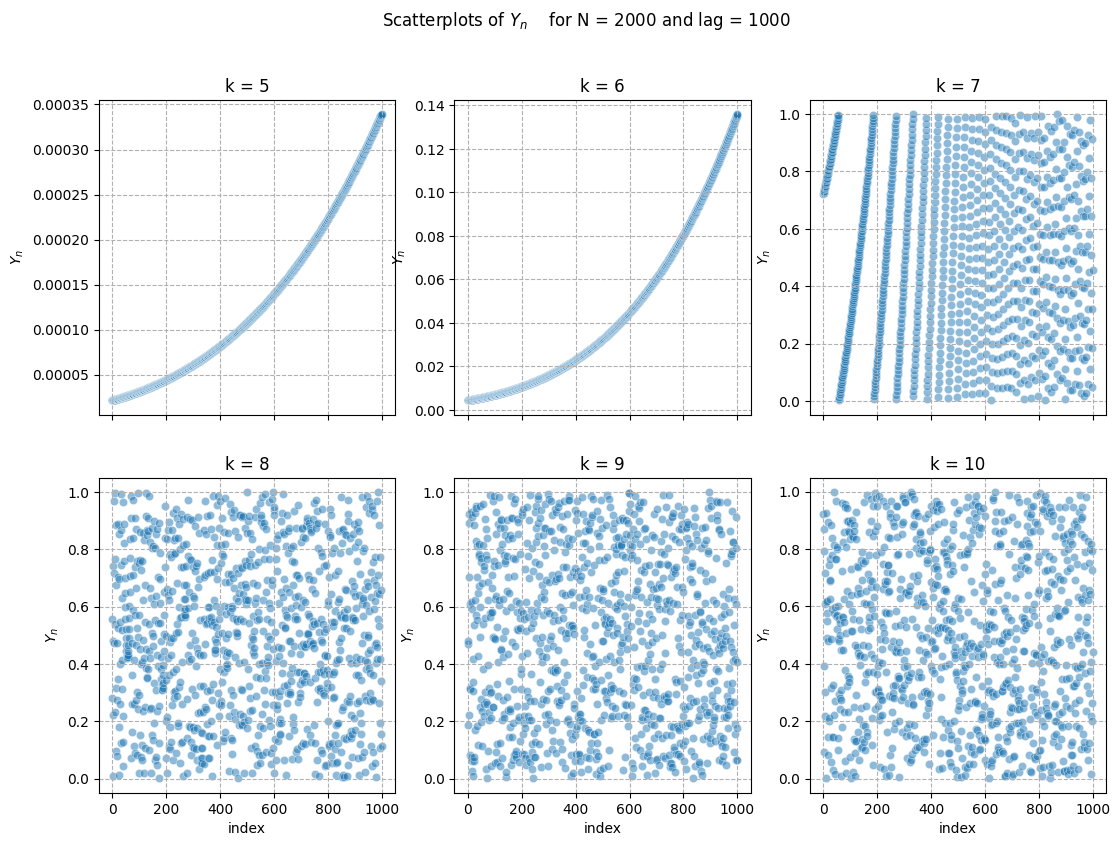

In [16]:
ks = [5, 6, 7, 8, 9, 10]
fig, axes = plt.subplots(2, 3, figsize=(13,9), sharex=True,)
N = 2000
lag = 1000
plt.suptitle("Scatterplots of $Y_{n} \quad $" + f" for N = {N} and lag = {lag}")
for i, ax in enumerate(axes.ravel()):
    Y = acorn2(N, k=ks[i], lag=1000)
    sns.scatterplot(ax=ax, x=range(len(Y)), y=Y, alpha=0.5)
    ax.set_title(f"k = {ks[i]}")
    ax.set_ylabel("$Y_n$")
    ax.set_xlabel("index")
    # ax.set_xlim(0, 1)

#### W tym miejscu badamy czy istnieje zależność między poprzednimi wyrazami ciągu.

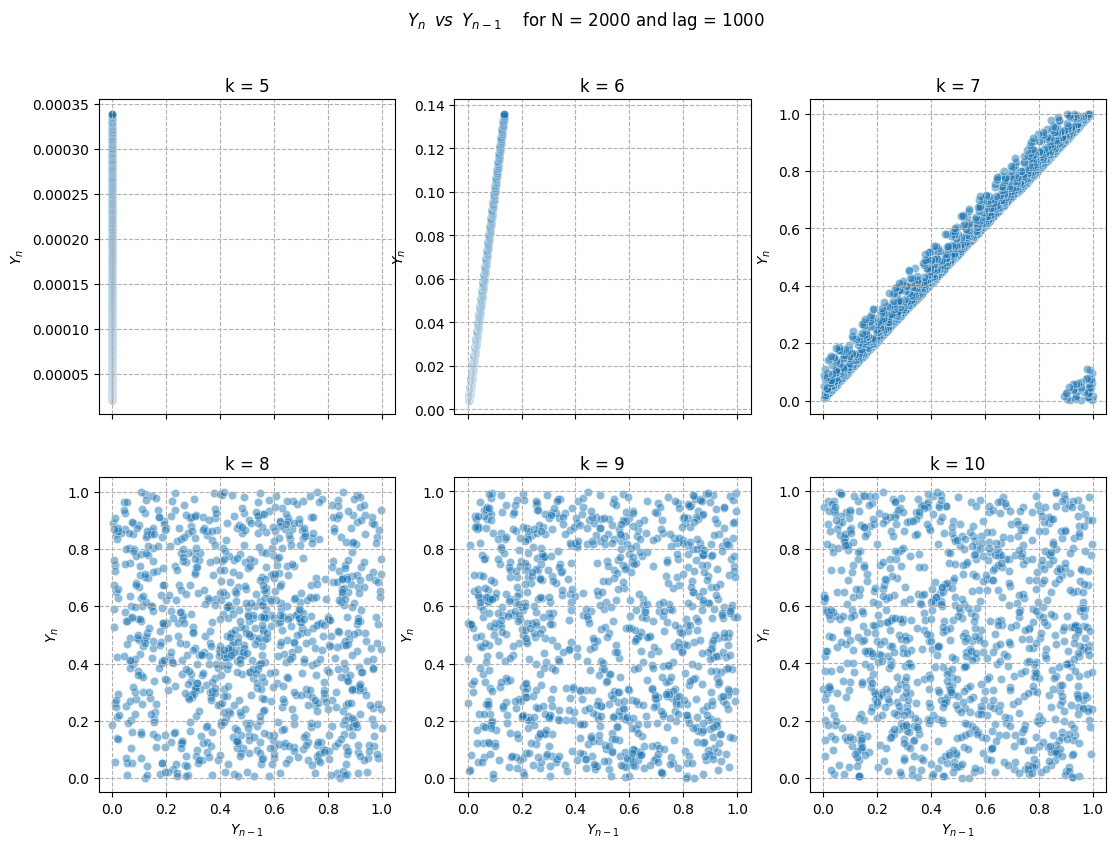

In [17]:
ks = [5, 6, 7, 8, 9, 10]
fig, axes = plt.subplots(2, 3, figsize=(13,9), sharex=True)
N = 2000
Lag = 1000
plt.suptitle("$Y_{n} \;\;vs\;\; Y_{n-1} \quad $" + f" for N = {N} and lag = {lag}")
plt.grid(linestyle="--")
for i, ax in enumerate(axes.ravel()):
    Y = acorn2(N, k=ks[i], lag=1000)
    sns.scatterplot(ax=ax, x=Y[:-1], y=Y[1:], alpha=0.5)
    ax.set_title(f"k = {ks[i]}")
    ax.set_ylabel("$Y_n$")
    ax.set_xlabel("$Y_{n-1}$")
    # ax.set_xlim(0, 1)


Widzimy, że dla $k < 8$, znając wartość wyrazu $Y_{n-1}$ jesteśmy w stanie z dużym prawdopodobieństwem estymować wartość $Y_n$, zatem w tych przypadkach, ciąg nie przypomina ciągu zmiennych losowych IID z rozkładu $U(0,1)$. Dla większych wartości parametru $k$ obserwujemy, że rozkład wygląda na znacznie bardziej zbliżony do jednostajnego. Aby z większą dokładnością ocenić czy rozkład przypomina $U(0,1)$ generujemy histogramy przyjmowanych wartości.

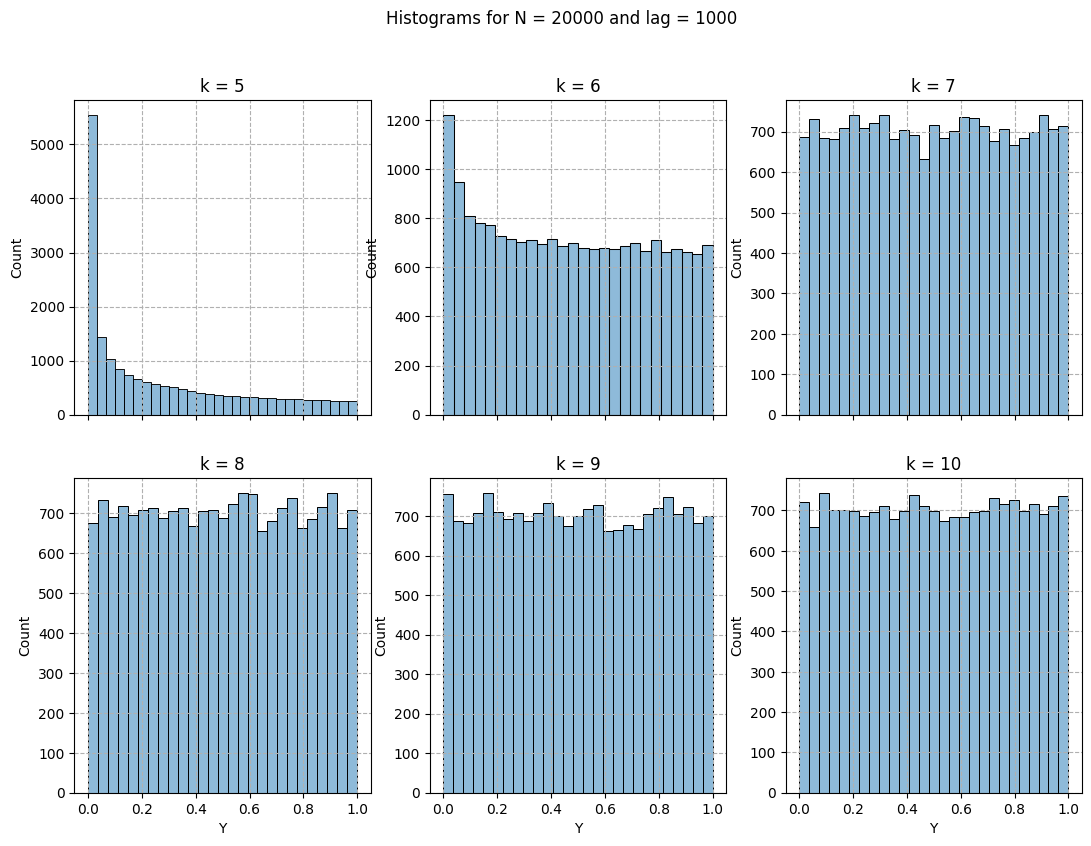

In [18]:
ks = [5, 6, 7, 8, 9, 10]
fig, axes = plt.subplots(2, 3, figsize=(13, 9), sharex=True)
N = 20_000
lag = 1000
plt.suptitle(f"Histograms for N = {N} and lag = {lag}")

for i, ax in enumerate(axes.ravel()):
    Y = acorn2(N, k=ks[i], lag=lag)
    sns.histplot(ax=ax, data=Y, alpha=0.5)
    ax.set_title(f"k = {ks[i]}")
    # ax.set_ylabel("")
    ax.set_xlabel("Y")

#### Wnioski:

 Widzimy, że już dla $k = 7$ prawdopodobieństwa wystąpienia poszczególnych wartości są bliskie równych. Biorąc jednak pod uwagę zależność wartości $Y_n$ od $Y_{n-1}$, dopiero dla $k >= 8$ algorytm generuje liczby pseudolosowe, których rozkład przypomina $U(0,1)$.

### Analiza wydajności implementacji

In [19]:
Ns = [1_000, 5_000, 10_000, 20_000, 50_000, 75_000, 100_000]
N = Ns[-1]
trials = 5 # number of measurements
times = np.zeros((len(Ns), 3))

for i, N in enumerate(Ns):
    times[i, 0] = timeit.timeit(f"acorn({N}, k=9, lag=1000)", setup="from __main__ import acorn", number=trials)
    times[i, 1] = timeit.timeit(f"acorn2({N}, k=9, lag=1000)", setup="from __main__ import acorn2", number=trials)
    times[i, 2] = timeit.timeit(f"np.random.rand({N})", setup="import numpy as np", number=trials)

times = times / trials

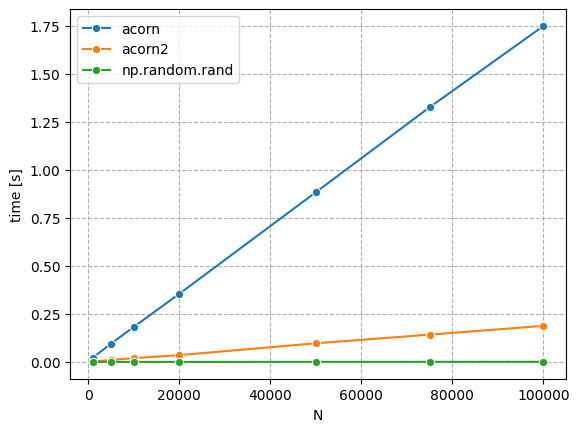

In [20]:
sns.lineplot(x=Ns, y=times[:, 0], marker="o", label="acorn")
sns.lineplot(x=Ns, y=times[:, 1], marker="o", label="acorn2")
sns.lineplot(x=Ns, y=times[:, 2], marker="o", label="np.random.rand")
plt.xlabel("N")
plt.ylabel("time [s]");

#### Wnioski:
Widzimy, że implementacja acorn2 okazała się znacznie efektywniejsza od pierwotnej wersji acorn. Najwydajniejsza okazała się funkcja np.random.rand dostępna w module NumPy.